In [1]:
# importing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from mpl_toolkits.mplot3d.axes3d import Axes3D
import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
import random
import math
import scipy
from scipy import stats  
import scipy.signal as signal  

In [2]:
!pip install plotly

In [3]:
# loading data
sd = pd.read_csv("Data/1_sample_data.csv")
sandstone_raw = sd.loc[(sd['Facies'] == 1)] # Group by facies (Sandstone)
shale_raw = sd.loc[(sd['Facies'] == 0)] # Group by facies (Shale)
seismic = np.loadtxt("Data/1_AI.csv", delimiter=",")
sandstone = pd.read_csv("Data/Sandstone_cleaned.csv")
shale = pd.read_csv("Data/Shale_cleaned.csv")
df_clean = pd.concat([shale, sandstone], axis=0)
del df_clean['Unnamed: 0']
del df_clean['Unnamed: 0.1']
df_raw = pd.concat([shale_raw, sandstone_raw], axis=0)
del df_raw['Unnamed: 0']

## 1. Performing Cell Declustering on porosity data (outliers removed) both facies included

In [4]:
wts, cell_sizes, dmeans = geostats.declus(df_clean,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
df_clean['Wts'] = wts                            # add weights to the sample data DataFrame
df_clean.head()                                  # preview to check the sample data DataFrame

There are 217 data with:
   mean of      0.13536741338554406 
   min and max  0.0606929054762965 and 0.20438817014234475
   standard dev 0.024034484994892254 


,X,Y,Facies,Porosity,Perm,AI,Wts
0,80.0,280.0,0.0,0.102919,0.196018,6753.323723,1.120736
1,160.0,840.0,0.0,0.128852,0.673043,6068.296567,0.920619
2,160.0,760.0,0.0,0.103365,5.368073,5574.433666,0.786815
3,160.0,120.0,0.0,0.142252,5.189214,7330.542384,2.111843
4,320.0,120.0,0.0,0.135132,1.850340,5501.993421,0.854673


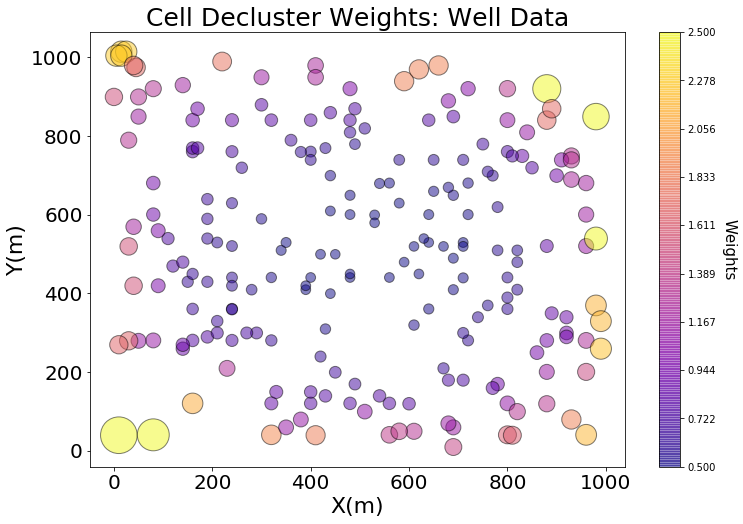

In [5]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of porosity values
plt.figure(figsize=(12,8))
im = plt.scatter(df_clean['X'],df_clean['Y'],s=200*df_clean['Wts'],c=df_clean['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

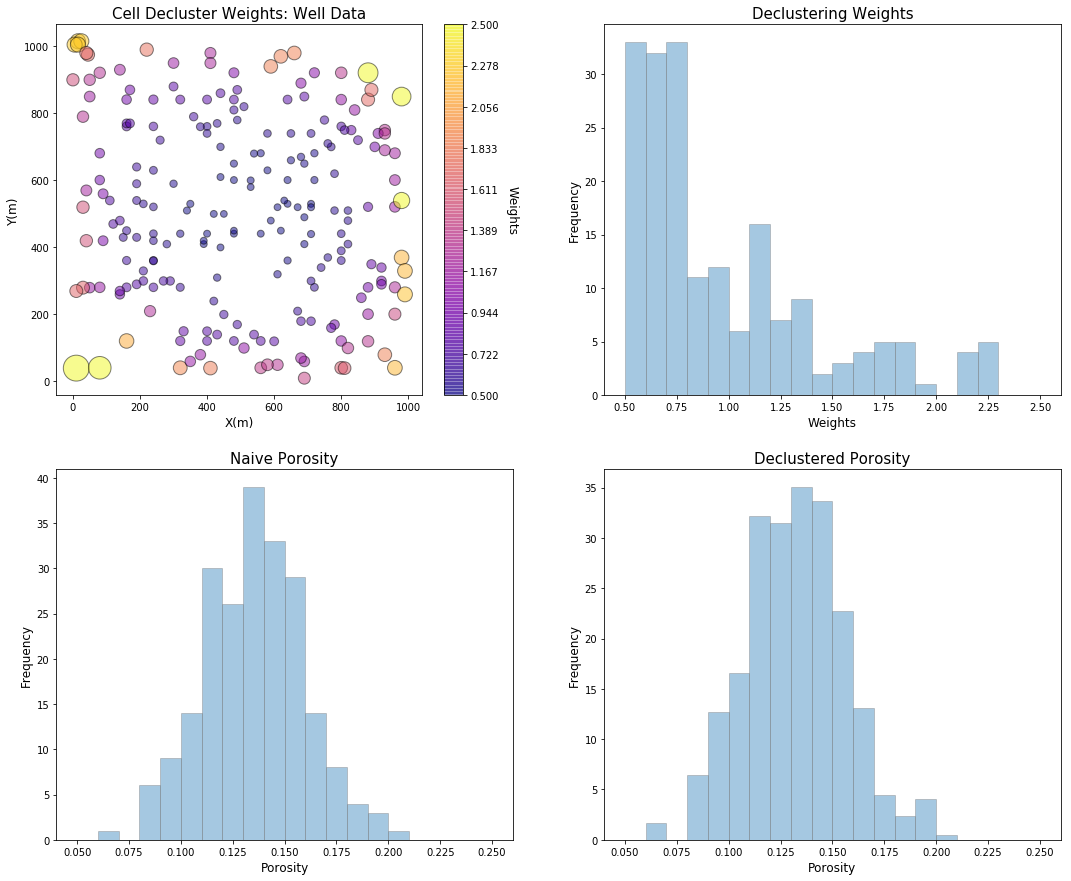

In [6]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(df_clean['X'],df_clean['Y'],s=100*df_clean['Wts'],c=df_clean['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Well Data', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(df_clean['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(df_clean['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(df_clean['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10],weights=df_clean['Wts'])
plt.title('Declustered Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

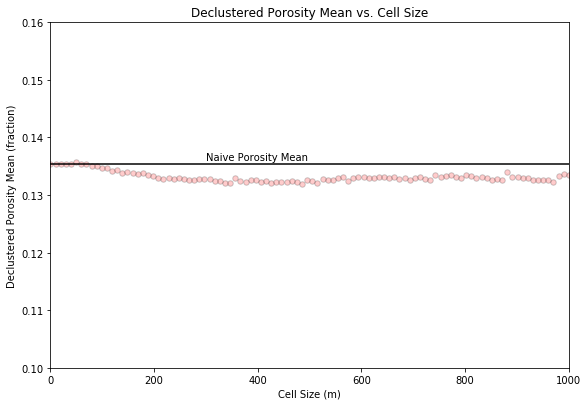

In [7]:
# decluster mean v cell size
por_mean = np.average(df_clean['Porosity'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Porosity Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.136, r'Naive Porosity Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [8]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 0.13196868224103886
Corresponding cell size: 485.19999999999953


For a field with dimensions 1000m x 1000m, choosing a cell size of 500m feels too large to me. Maybe a lower value of 200m or 250m is more appropriate.

## 2. Cell declustering on shale porosity values (outliers removed)

In [9]:
wts, cell_sizes, dmeans = geostats.declus(shale,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
shale['Wts'] = wts                            # add weights to the sample data DataFrame
shale.head()                                  # preview to check the sample data DataFrame

There are 53 data with:
   mean of      0.11501478234971194 
   min and max  0.0606929054762965 and 0.16093715216411694
   standard dev 0.020763656808223074 


,Unnamed: 0,Unnamed: 0.1,X,Y,Facies,Porosity,Perm,AI,Wts
0,3,8,80.0,280.0,0.0,0.102919,0.196018,6753.323723,1.0
1,5,13,160.0,840.0,0.0,0.128852,0.673043,6068.296567,1.0
2,6,14,160.0,760.0,0.0,0.103365,5.368073,5574.433666,1.0
3,10,22,160.0,120.0,0.0,0.142252,5.189214,7330.542384,1.0
4,20,46,320.0,120.0,0.0,0.135132,1.850340,5501.993421,1.0


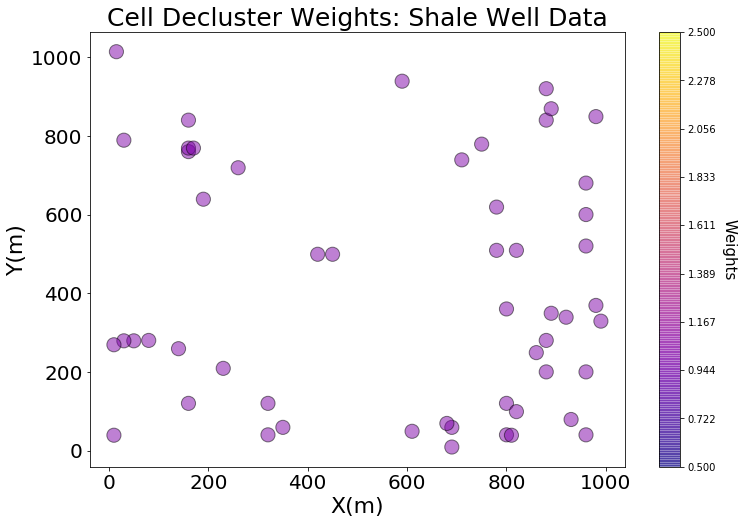

In [10]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of porosity values
plt.figure(figsize=(12,8))
im = plt.scatter(shale['X'],shale['Y'],s=200*shale['Wts'],c=shale['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Shale Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

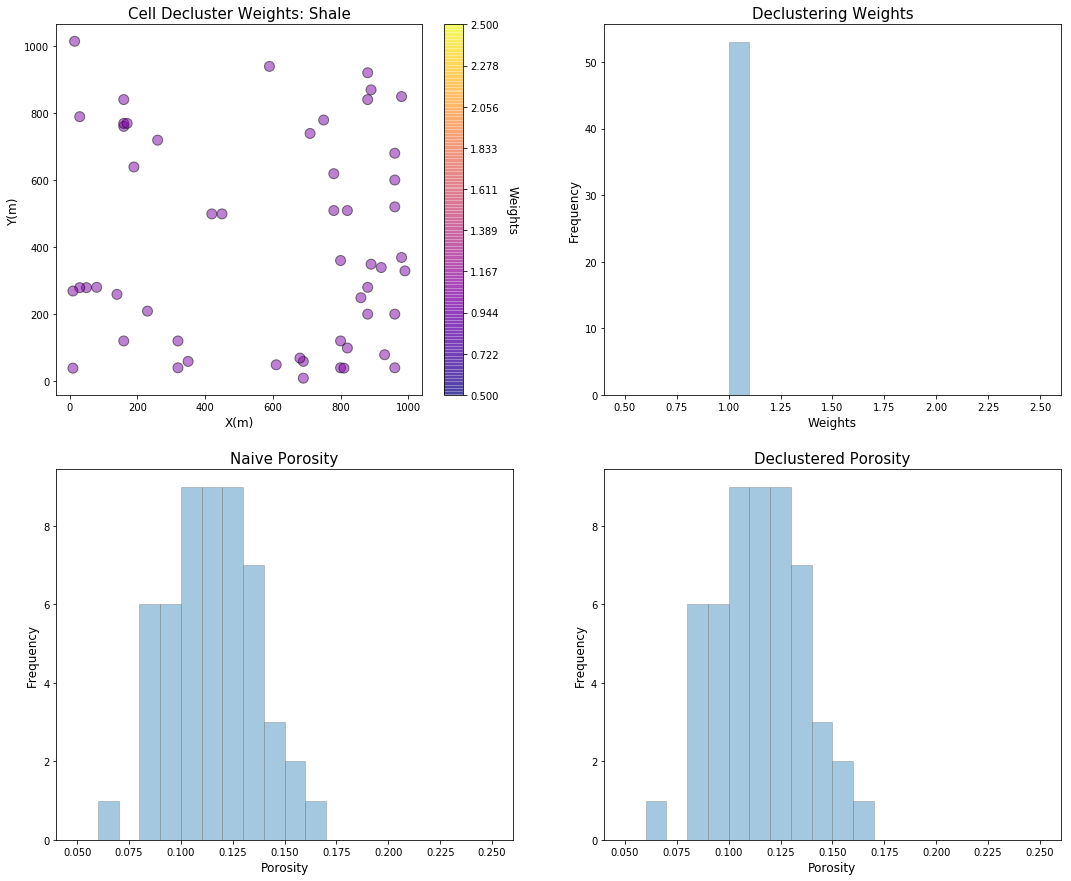

In [11]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(shale['X'],shale['Y'],s=100*shale['Wts'],c=shale['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Shale', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(shale['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(shale['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(shale['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10],weights=shale['Wts'])
plt.title('Declustered Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

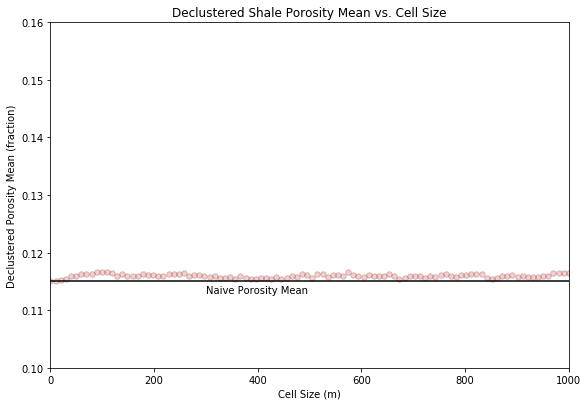

In [12]:
# mean v cell size
por_mean = np.average(shale['Porosity'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Shale Porosity Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.113, r'Naive Porosity Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [13]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 0.11501478234971194
Corresponding cell size: 0.0


No noticable change due to the application of cell declustering

## 3. Cell declustering on sandstone porosity values (outliers removed)

In [14]:
wts, cell_sizes, dmeans = geostats.declus(sandstone,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
sandstone['Wts'] = wts                            # add weights to the sample data DataFrame
sandstone.head()                                  # preview to check the sample data DataFrame

There are 164 data with:
   mean of      0.14194478804956295 
   min and max  0.09586122454769302 and 0.20438817014234475
   standard dev 0.021163198662676658 


,Unnamed: 0,Unnamed: 0.1,X,Y,Facies,Porosity,Perm,AI,Wts
0,0,0,80.0,920.0,1.0,0.164331,69.106615,5012.616594,1.351359
1,1,3,80.0,680.0,1.0,0.133723,1.558072,5710.579850,0.898230
2,2,4,80.0,600.0,1.0,0.096295,3.568959,4912.388066,1.036278
3,4,11,80.0,40.0,1.0,0.145738,0.109943,6492.944055,7.177127
4,8,19,160.0,360.0,1.0,0.148611,45.082381,6643.024955,0.727677


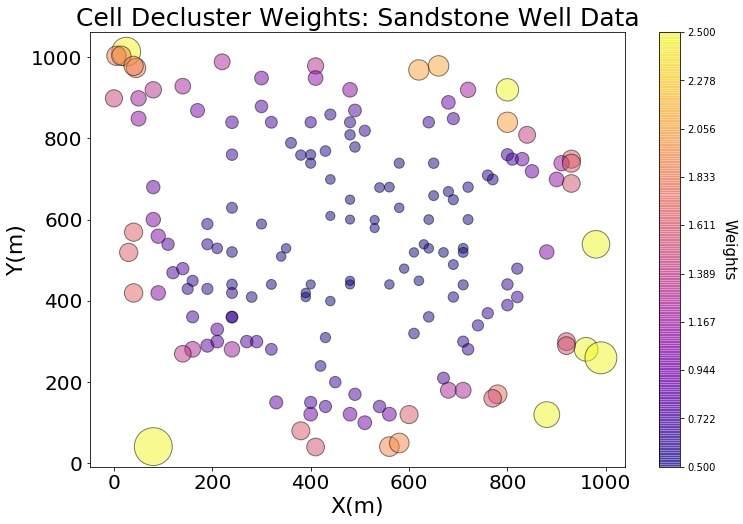

In [15]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of porosity values
plt.figure(figsize=(12,8))
im = plt.scatter(sandstone['X'],sandstone['Y'],s=200*sandstone['Wts'],c=sandstone['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Sandstone Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

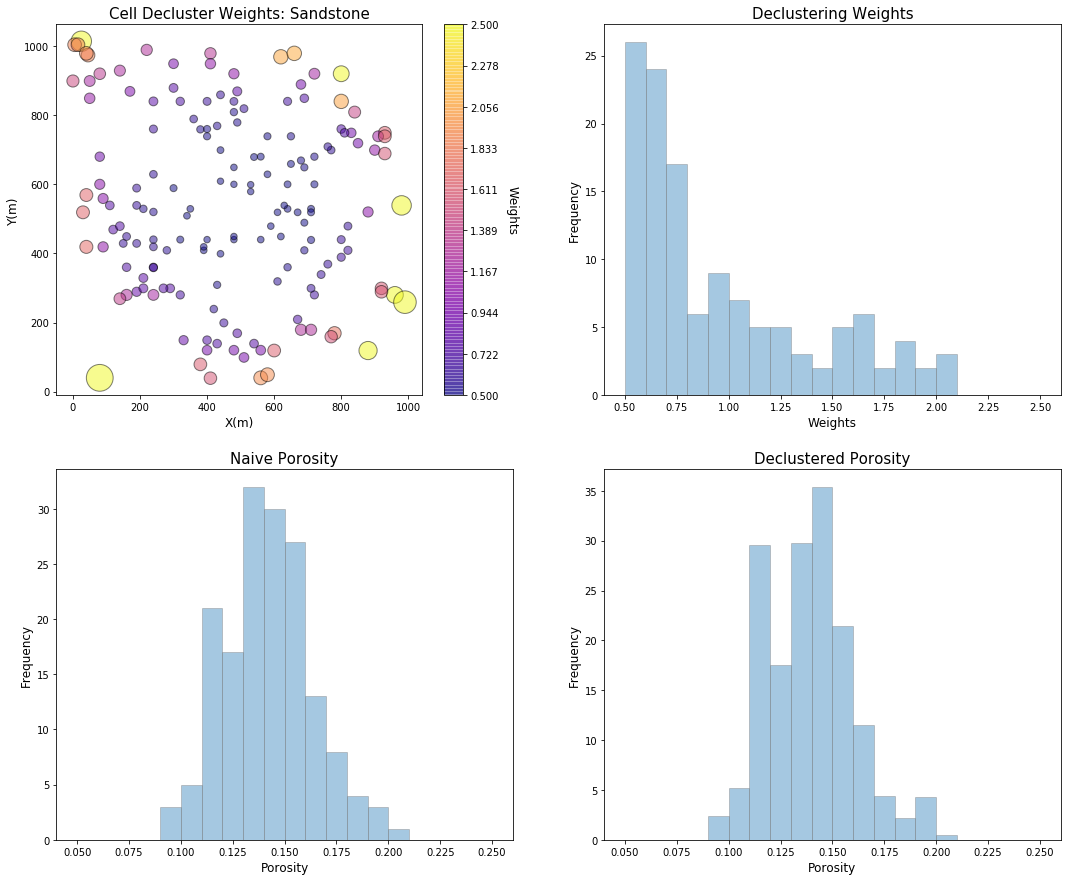

In [16]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(sandstone['X'],sandstone['Y'],s=100*sandstone['Wts'],c=sandstone['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Sandstone', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(sandstone['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(sandstone['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(sandstone['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10],weights=sandstone['Wts'])
plt.title('Declustered Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

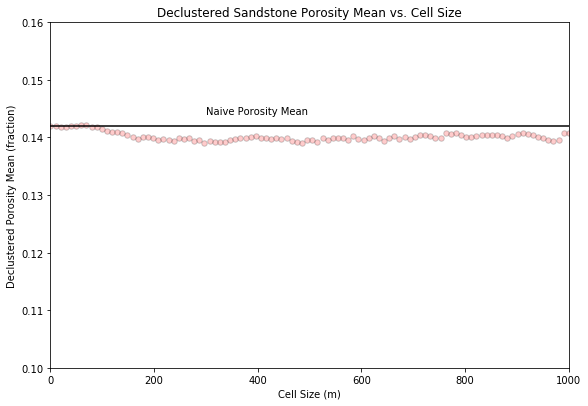

In [17]:
# mean v cell size
por_mean = np.average(sandstone['Porosity'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Sandstone Porosity Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.144, r'Naive Porosity Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [18]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 0.1389551223674361
Corresponding cell size: 485.19999999999953


The entire field of interest is only 1000m x 1000m so it would not be logical to use a cell size close to 500m or half that size. Instead by looking at the plot it appears as if the declustered mean is lowered to an oscillating value by the time the cell size grows to be about 200m.

## 4. Performing Cell Declustering on porosity data (raw data) both facies included

In [19]:
wts, cell_sizes, dmeans = geostats.declus(df_raw,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
df_raw['Wts'] = wts                            # add weights to the sample data DataFrame
df_raw.head()                                  # preview to check the sample data DataFrame

There are 271 data with:
   mean of      0.14170682372612756 
   min and max  0.0606929054762965 and 0.2216072275194954
   standard dev 0.02828848709981607 


,X,Y,Facies,Porosity,Perm,AI,Wts
3,80.0,280.0,0.0,0.102919,0.196018,6753.323723,1.212966
5,160.0,840.0,0.0,0.128852,0.673043,6068.296567,1.008830
6,160.0,760.0,0.0,0.103365,5.368073,5574.433666,0.878734
7,160.0,680.0,0.0,0.126885,24.314420,4201.709904,0.887110
10,160.0,120.0,0.0,0.142252,5.189214,7330.542384,2.489326


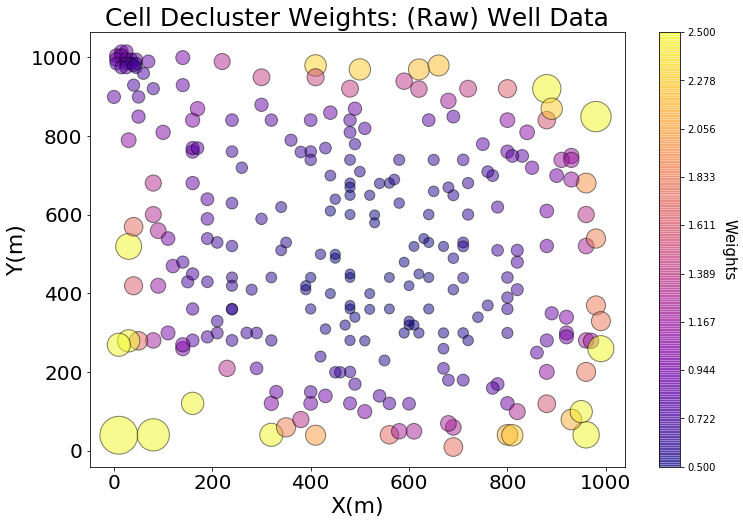

In [20]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of porosity values
plt.figure(figsize=(12,8))
im = plt.scatter(df_raw['X'],df_raw['Y'],s=200*df_raw['Wts'],c=df_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: (Raw) Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

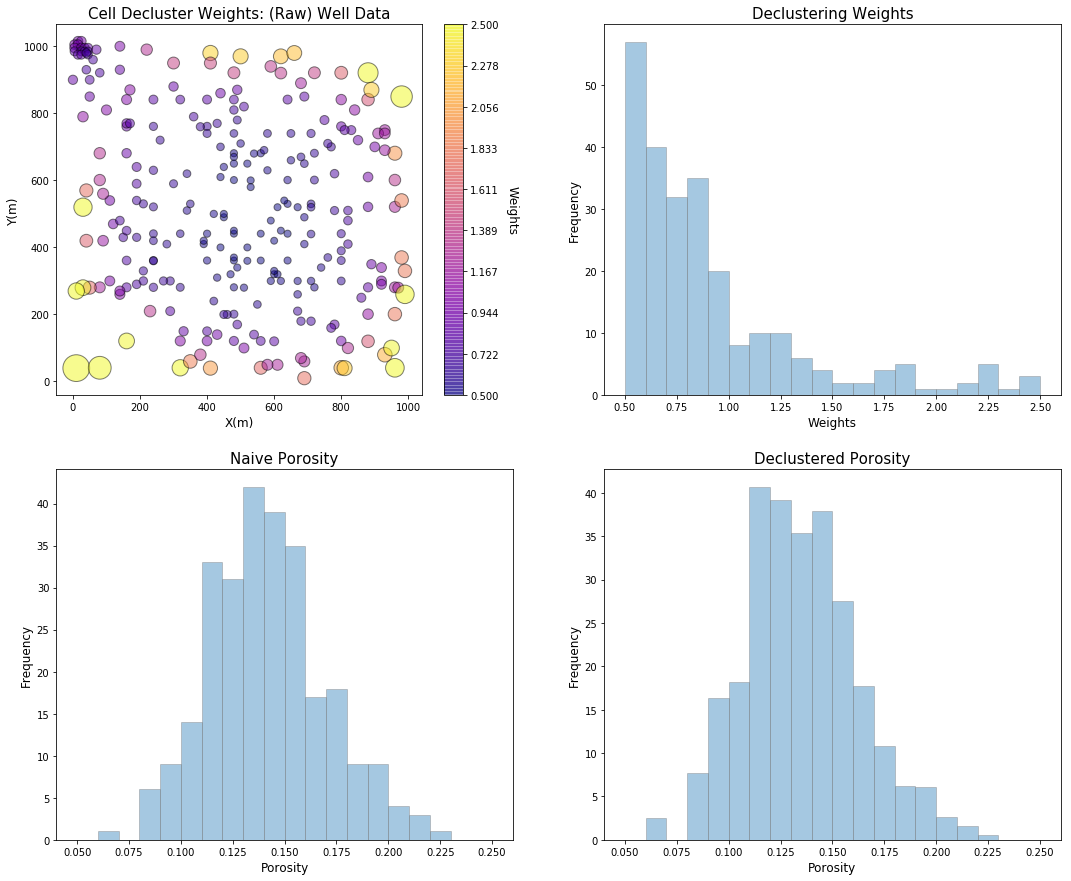

In [21]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(df_raw['X'],df_raw['Y'],s=100*df_raw['Wts'],c=df_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: (Raw) Well Data', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(df_raw['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(df_raw['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(df_raw['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10],weights=df_raw['Wts'])
plt.title('Declustered Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

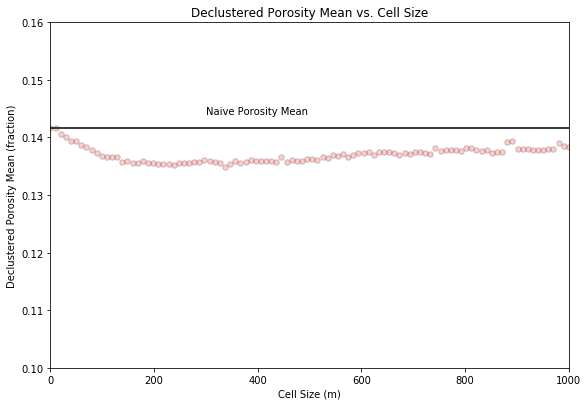

In [22]:
# decluster mean v cell size
por_mean = np.average(df_raw['Porosity'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Porosity Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.144, r'Naive Porosity Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [23]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 0.1349271389045145
Corresponding cell size: 336.6999999999999


For a field with dimensions 1000m x 1000m, choosing a cell size of 300m is large, but from looking at the plot of the porosity mean v cell size, choosing 200m cells appears to be a reasonable choice as well.

## 5. Cell declustering on shale porosity values (raw data with outliers)

In [24]:
# Warning that appears is notification that DataFrame is being changed not copied
wts, cell_sizes, dmeans = geostats.declus(shale_raw,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
shale_raw['Wts'] = wts                            # add weights to the sample data DataFrame
shale_raw.head()                                  # preview to check the sample data DataFrame

There are 62 data with:
   mean of      0.11684148604737674 
   min and max  0.0606929054762965 and 0.16093715216411694
   standard dev 0.020261552852745553 


C:\Users\Navas Archila Family\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,Wts
3,8,80.0,280.0,0.0,0.102919,0.196018,6753.323723,0.931062
5,13,160.0,840.0,0.0,0.128852,0.673043,6068.296567,1.084776
6,14,160.0,760.0,0.0,0.103365,5.368073,5574.433666,0.743066
7,15,160.0,680.0,0.0,0.126885,24.314420,4201.709904,0.902986
10,22,160.0,120.0,0.0,0.142252,5.189214,7330.542384,1.369408


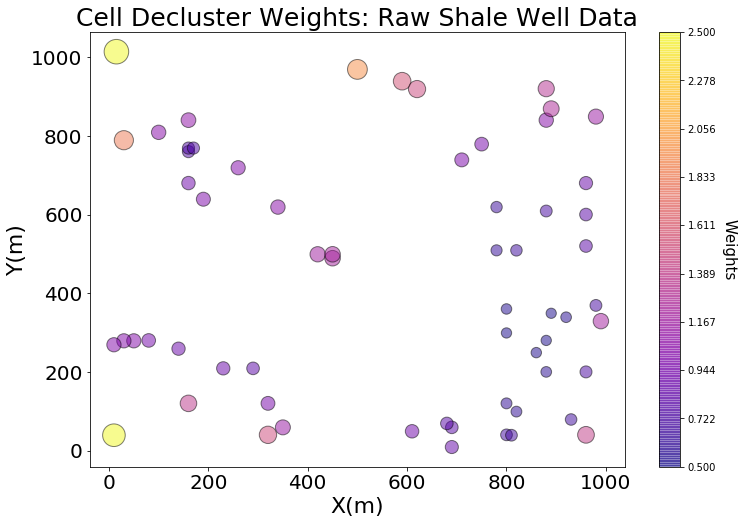

In [25]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of porosity values
plt.figure(figsize=(12,8))
im = plt.scatter(shale_raw['X'],shale_raw['Y'],s=200*shale_raw['Wts'],
                 c=shale_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,
                 vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Shale Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

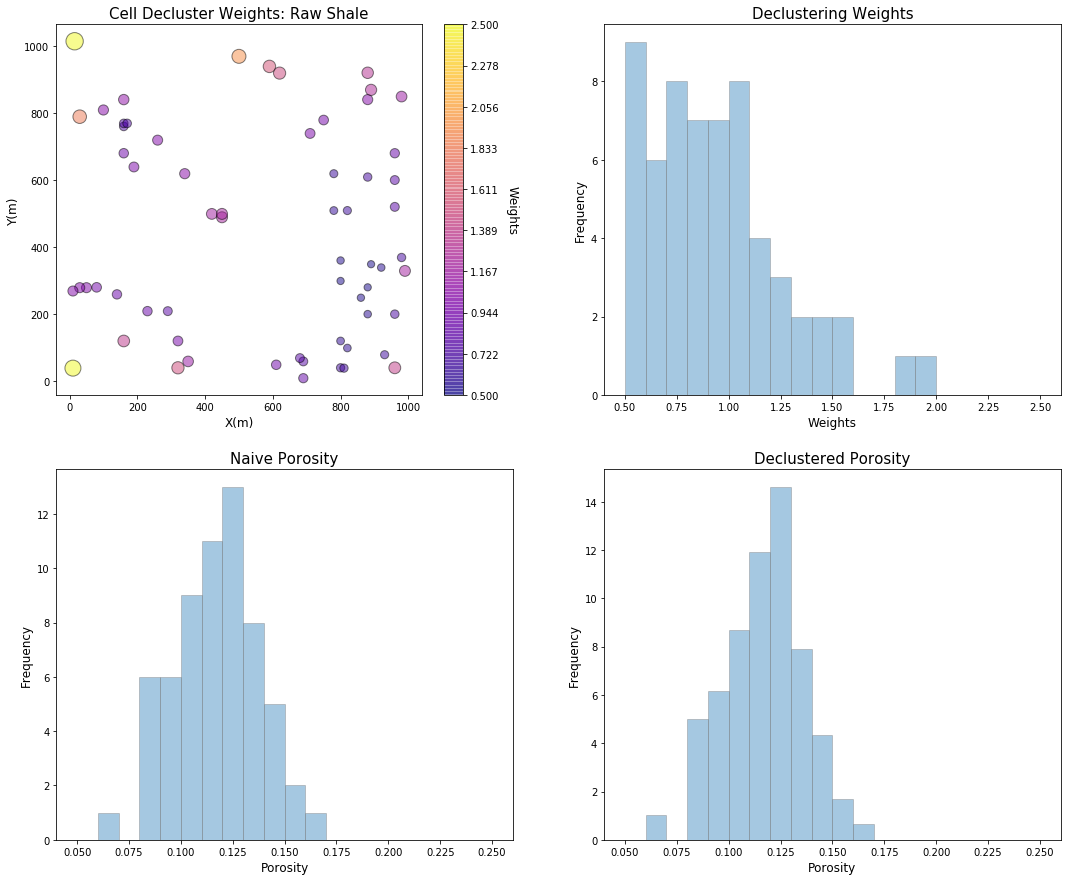

In [26]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(shale_raw['X'],shale_raw['Y'],s=100*shale_raw['Wts'],
                 c=shale_raw['Wts'],marker=None,cmap=plt.cm.plasma,
                 norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Shale', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(shale_raw['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(shale_raw['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(shale_raw['Porosity'],edgecolor='gray',bins=20,alpha=0.4,
                     range=[vmin/10,vmax/10],weights=shale_raw['Wts'])
plt.title('Declustered Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

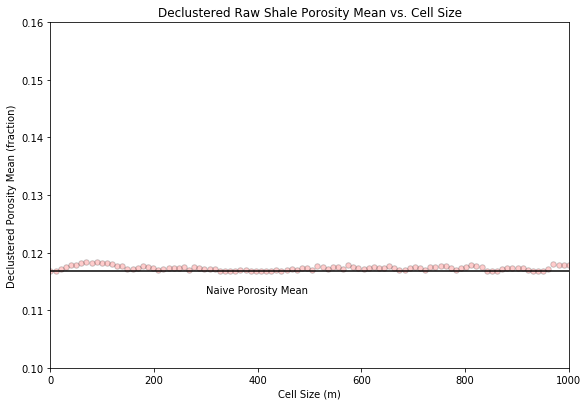

In [27]:
# mean v cell size
por_mean = np.average(shale_raw['Porosity'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Raw Shale Porosity Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.113, r'Naive Porosity Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [28]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 0.11673087358883076
Corresponding cell size: 425.79999999999967


Visual inspection of the field would suggest that a cell size of ~1000m will not be particularly illuminating. Looking at the plot of the declustered mean against the cell size, it does not appear to favor any particular size.

## 6. Cell declustering on sandstone porosity values (raw data)

In [29]:
# Warning that appears is notification that DataFrame is being changed not copied
wts, cell_sizes, dmeans = geostats.declus(sandstone_raw,'X','Y','Porosity',
                                          iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
sandstone_raw['Wts'] = wts                            # add weights to the sample data DataFrame
sandstone_raw.head()                                  # preview to check the sample data DataFrame

There are 209 data with:
   mean of      0.14908314399446512 
   min and max  0.09586122454769302 and 0.2216072275194954
   standard dev 0.026038833669755866 


C:\Users\Navas Archila Family\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,Wts
0,0,80.0,920.0,1.0,0.164331,69.106615,5012.616594,0.724622
1,3,80.0,680.0,1.0,0.133723,1.558072,5710.579850,2.674839
2,4,80.0,600.0,1.0,0.096295,3.568959,4912.388066,1.261148
4,11,80.0,40.0,1.0,0.145738,0.109943,6492.944055,8.711087
8,19,160.0,360.0,1.0,0.148611,45.082381,6643.024955,0.733433


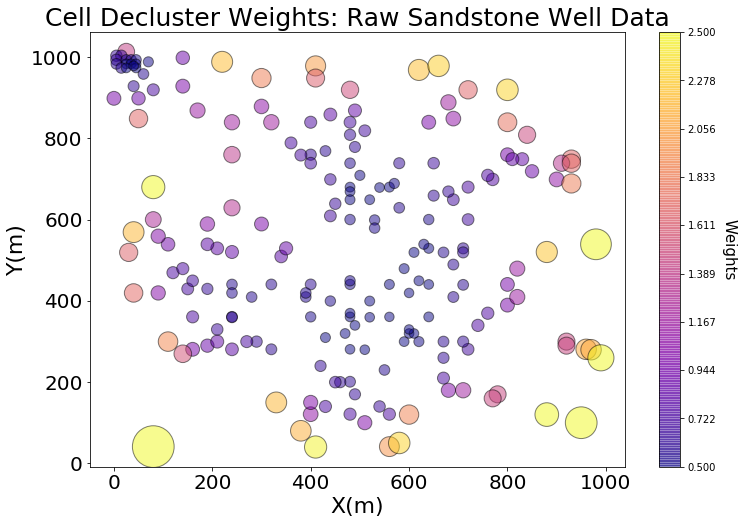

In [30]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of porosity values
plt.figure(figsize=(12,8))
im = plt.scatter(sandstone_raw['X'],sandstone_raw['Y'],s=200*sandstone_raw['Wts'],
                 c=sandstone_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,
                 vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Sandstone Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

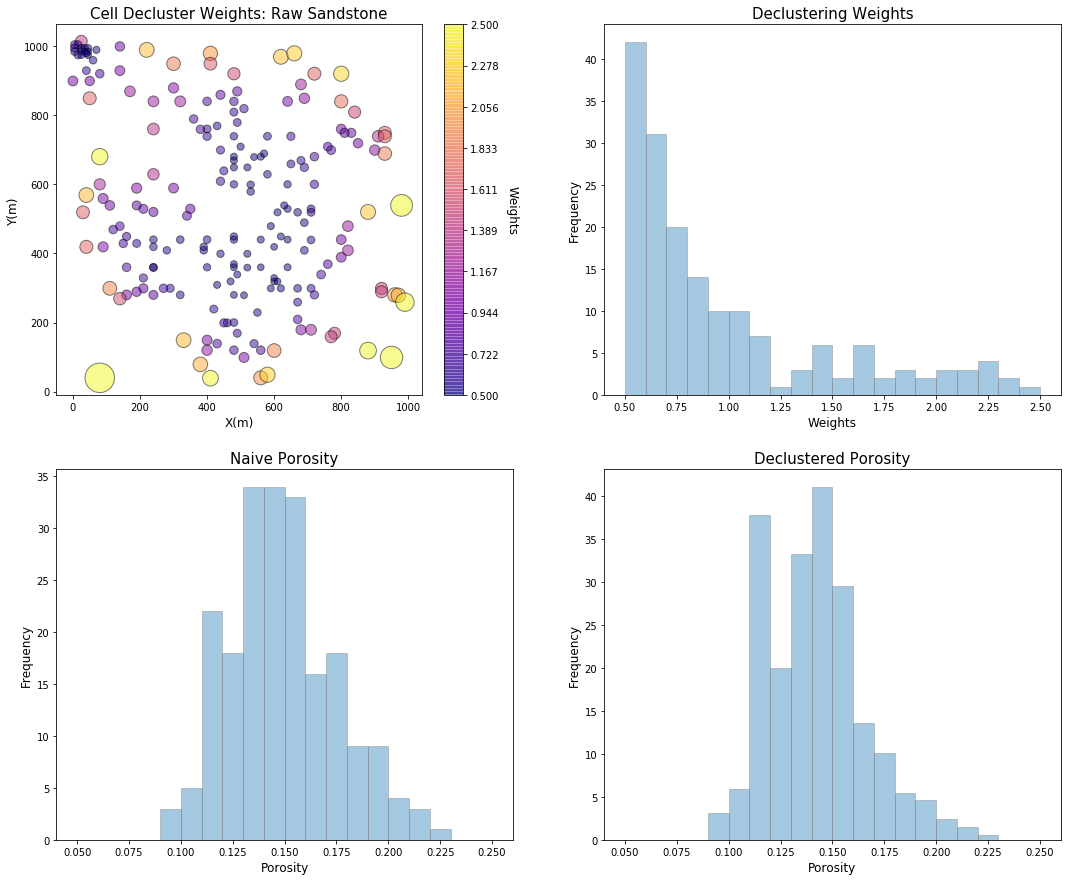

In [31]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(sandstone_raw['X'],sandstone_raw['Y'],s=100*sandstone_raw['Wts'],
                 c=sandstone_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,
                 vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Sandstone', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(sandstone_raw['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(sandstone_raw['Porosity'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(sandstone_raw['Porosity'],edgecolor='gray',bins=20,alpha=0.4,
                     range=[vmin/10,vmax/10],weights=sandstone_raw['Wts'])
plt.title('Declustered Porosity',size=15)
plt.xlabel('Porosity',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

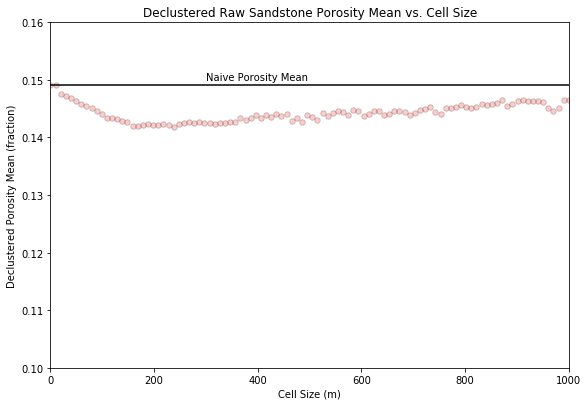

In [32]:
# mean v cell size
por_mean = np.average(sandstone_raw['Porosity'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Raw Sandstone Porosity Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.150, r'Naive Porosity Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [33]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 0.14187618800436513
Corresponding cell size: 237.70000000000007


With some rounding, we may be comfortable using a cell size of 200m based on this declustering analysis. Visual analysis of the field would suggest that this cell size provides reasonable coverage of the data, despite some cells that might be sparse near some of the boundaries.

## 7. Performing Cell Declustering on Permeability data (outliers removed) both facies included

In [34]:
wts, cell_sizes, dmeans = geostats.declus(df_clean,'X','Y','Perm',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
df_clean['Wts_perm'] = wts                            # add weights to the sample data DataFrame
df_clean.head()                                  # preview to check the sample data DataFrame

There are 217 data with:
   mean of      18.03598925977938 
   min and max  0.01805446870059259 and 193.74682353970672
   standard dev 31.50772559252999 


,X,Y,Facies,Porosity,Perm,AI,Wts,Wts_perm
0,80.0,280.0,0.0,0.102919,0.196018,6753.323723,1.120736,1.269533
1,160.0,840.0,0.0,0.128852,0.673043,6068.296567,0.920619,0.926044
2,160.0,760.0,0.0,0.103365,5.368073,5574.433666,0.786815,0.806083
3,160.0,120.0,0.0,0.142252,5.189214,7330.542384,2.111843,2.732758
4,320.0,120.0,0.0,0.135132,1.850340,5501.993421,0.854673,0.858297


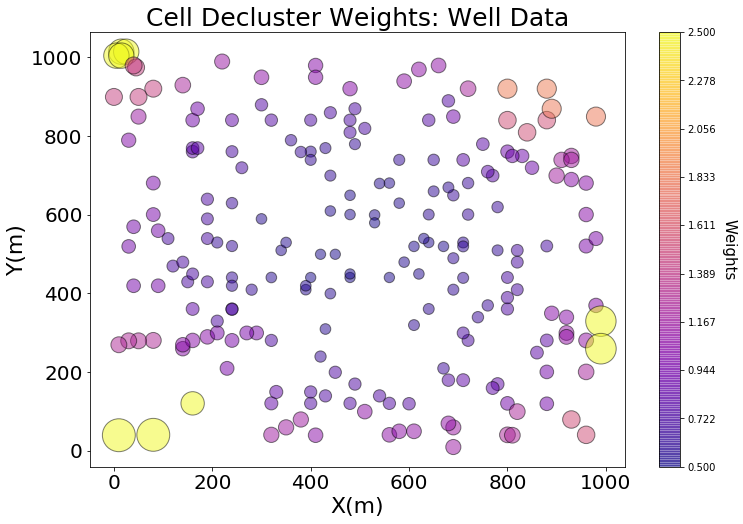

In [35]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of permeability values
plt.figure(figsize=(12,8))
im = plt.scatter(df_clean['X'],df_clean['Y'],s=200*df_clean['Wts_perm'],c=df_clean['Wts_perm'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

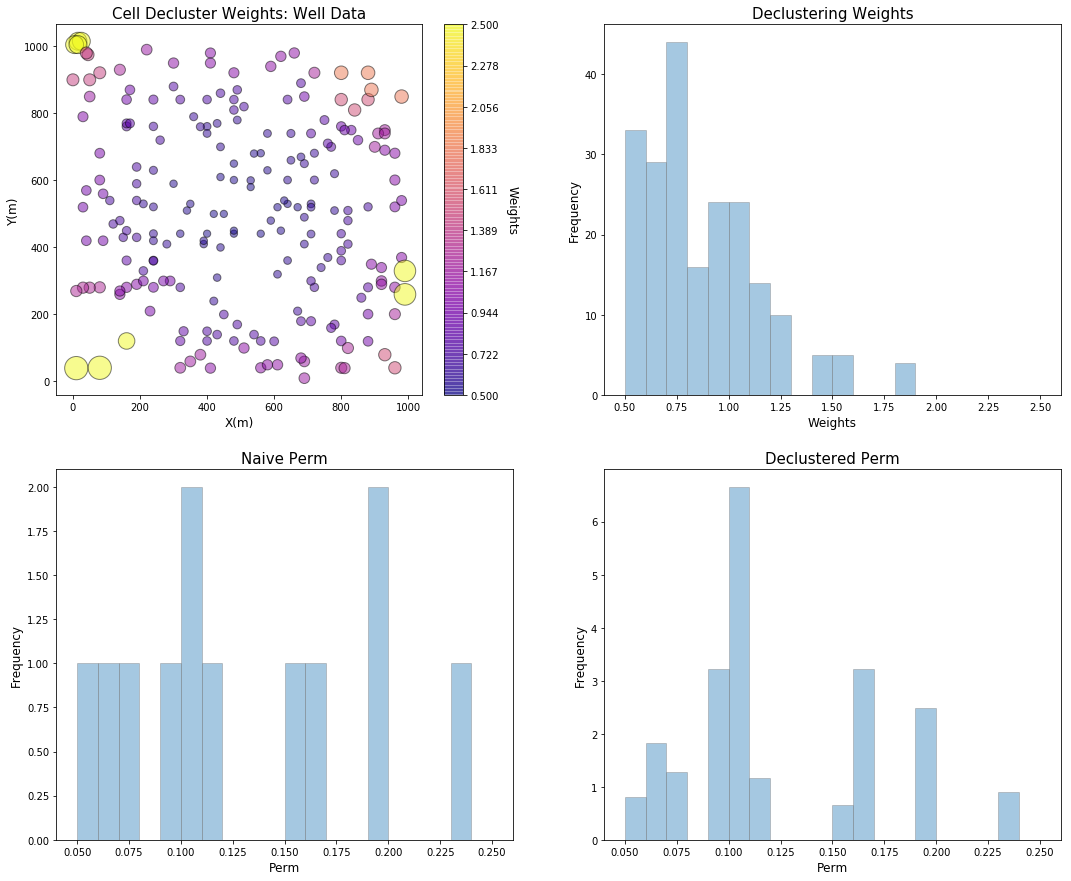

In [36]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of permeability values
im = plt.scatter(df_clean['X'],df_clean['Y'],s=100*df_clean['Wts_perm'],c=df_clean['Wts_perm'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Well Data', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(df_clean['Wts_perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(df_clean['Perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(df_clean['Perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10],weights=df_clean['Wts_perm'])
plt.title('Declustered Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

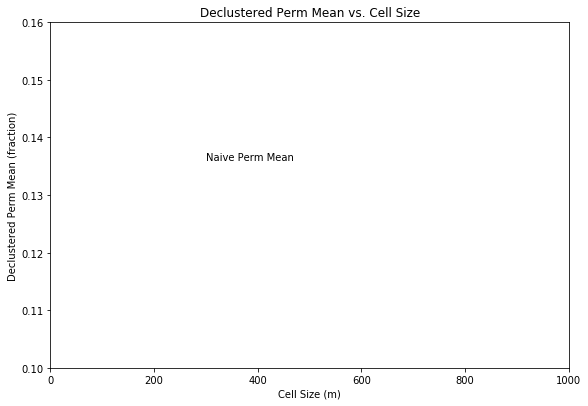

In [37]:
# decluster mean v cell size
per_mean = np.average(df_clean['Perm'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Perm Mean (fraction)')
plt.title('Declustered Perm Mean vs. Cell Size')
plt.plot([0,1000],[per_mean,per_mean],color = 'black')
plt.text(300., 0.136, r'Naive Perm Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [38]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 14.279931400315252
Corresponding cell size: 980.1999999999985


For a field with dimensions 1000m x 1000m, choosing a cell size of 500m feels too large to me. Maybe a lower value of 200m or 250m is more appropriate.

## 8. Cell declustering on shale permeability values (outliers removed)

In [39]:
wts, cell_sizes, dmeans = geostats.declus(shale,'X','Y','Perm',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
shale['Wts_perm'] = wts                            # add weights to the sample data DataFrame
shale.head()                                  # preview to check the sample data DataFrame

There are 53 data with:
   mean of      2.573465714625458 
   min and max  0.01805446870059259 and 11.605383191006649
   standard dev 3.0299654576750528 


,Unnamed: 0,Unnamed: 0.1,X,Y,Facies,Porosity,Perm,AI,Wts,Wts_perm
0,3,8,80.0,280.0,0.0,0.102919,0.196018,6753.323723,1.0,1.034082
1,5,13,160.0,840.0,0.0,0.128852,0.673043,6068.296567,1.0,1.494791
2,6,14,160.0,760.0,0.0,0.103365,5.368073,5574.433666,1.0,1.097291
3,10,22,160.0,120.0,0.0,0.142252,5.189214,7330.542384,1.0,1.403189
4,20,46,320.0,120.0,0.0,0.135132,1.850340,5501.993421,1.0,0.741338


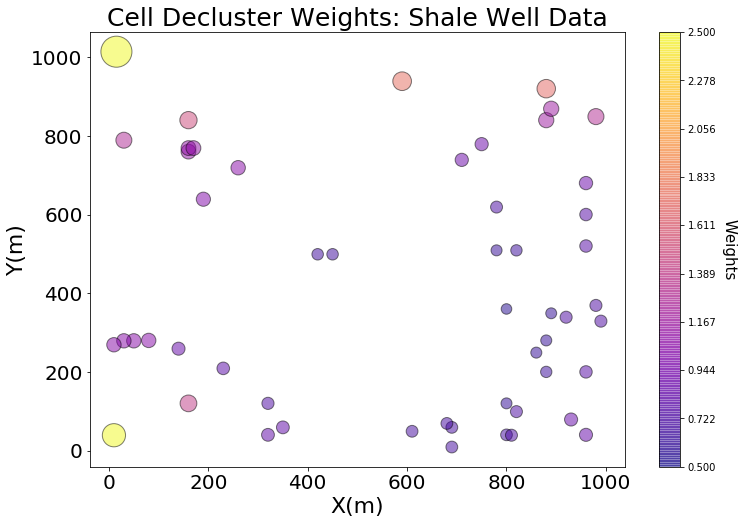

In [40]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of permeability values
plt.figure(figsize=(12,8))
im = plt.scatter(shale['X'],shale['Y'],s=200*shale['Wts_perm'],c=shale['Wts_perm'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Shale Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

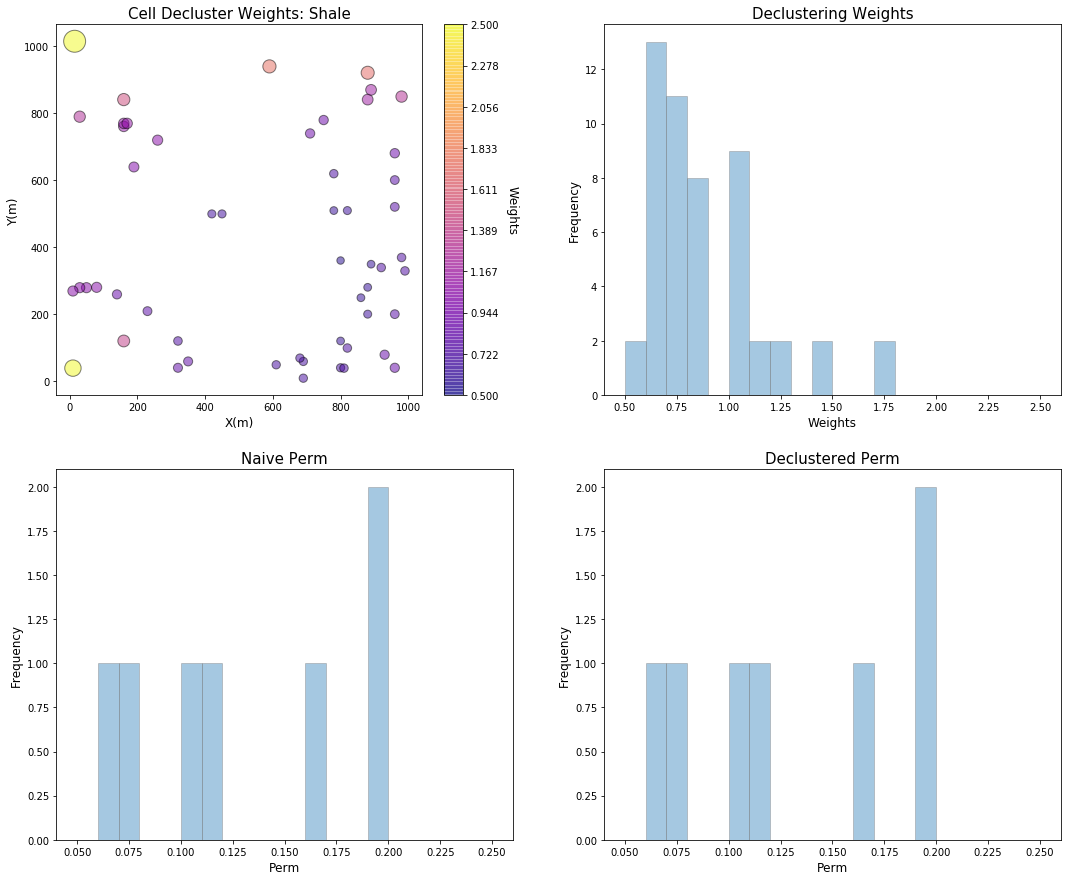

In [41]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of permeability values
im = plt.scatter(shale['X'],shale['Y'],s=100*shale['Wts_perm'],c=shale['Wts_perm'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Shale', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(shale['Wts_perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(shale['Perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(shale['Perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10],weights=shale['Wts'])
plt.title('Declustered Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

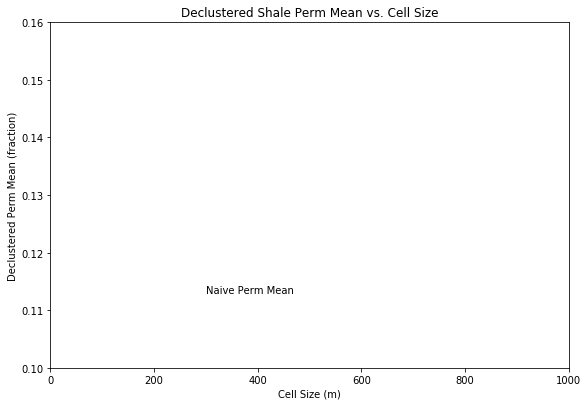

In [42]:
# mean v cell size
por_mean = np.average(shale['Perm'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Perm Mean (fraction)')
plt.title('Declustered Shale Perm Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.113, r'Naive Perm Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [43]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 2.2745153238064613
Corresponding cell size: 990.0999999999984


No noticable change due to the application of cell declustering

## 9. Cell declustering on sandstone permeability values (outliers removed)

In [44]:
wts, cell_sizes, dmeans = geostats.declus(sandstone,'X','Y','Perm',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
sandstone['Wts_perm'] = wts                            # add weights to the sample data DataFrame
sandstone.head()                                  # preview to check the sample data DataFrame

There are 164 data with:
   mean of      23.03302430790839 
   min and max  0.051426329492133584 and 193.74682353970672
   standard dev 34.76141796785542 


,Unnamed: 0,Unnamed: 0.1,X,Y,Facies,Porosity,Perm,AI,Wts,Wts_perm
0,0,0,80.0,920.0,1.0,0.164331,69.106615,5012.616594,1.351359,1.351359
1,1,3,80.0,680.0,1.0,0.133723,1.558072,5710.579850,0.898230,0.898230
2,2,4,80.0,600.0,1.0,0.096295,3.568959,4912.388066,1.036278,1.036278
3,4,11,80.0,40.0,1.0,0.145738,0.109943,6492.944055,7.177127,7.177127
4,8,19,160.0,360.0,1.0,0.148611,45.082381,6643.024955,0.727677,0.727677


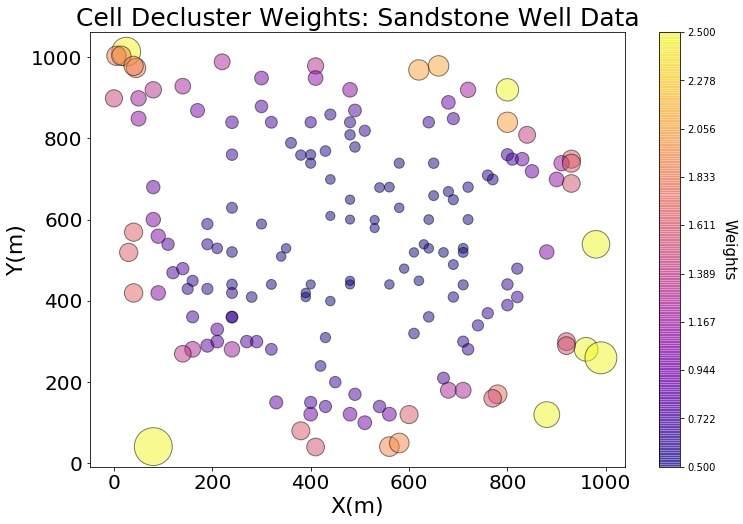

In [45]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of permeability values
plt.figure(figsize=(12,8))
im = plt.scatter(sandstone['X'],sandstone['Y'],s=200*sandstone['Wts_perm'],c=sandstone['Wts_perm'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Sandstone Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

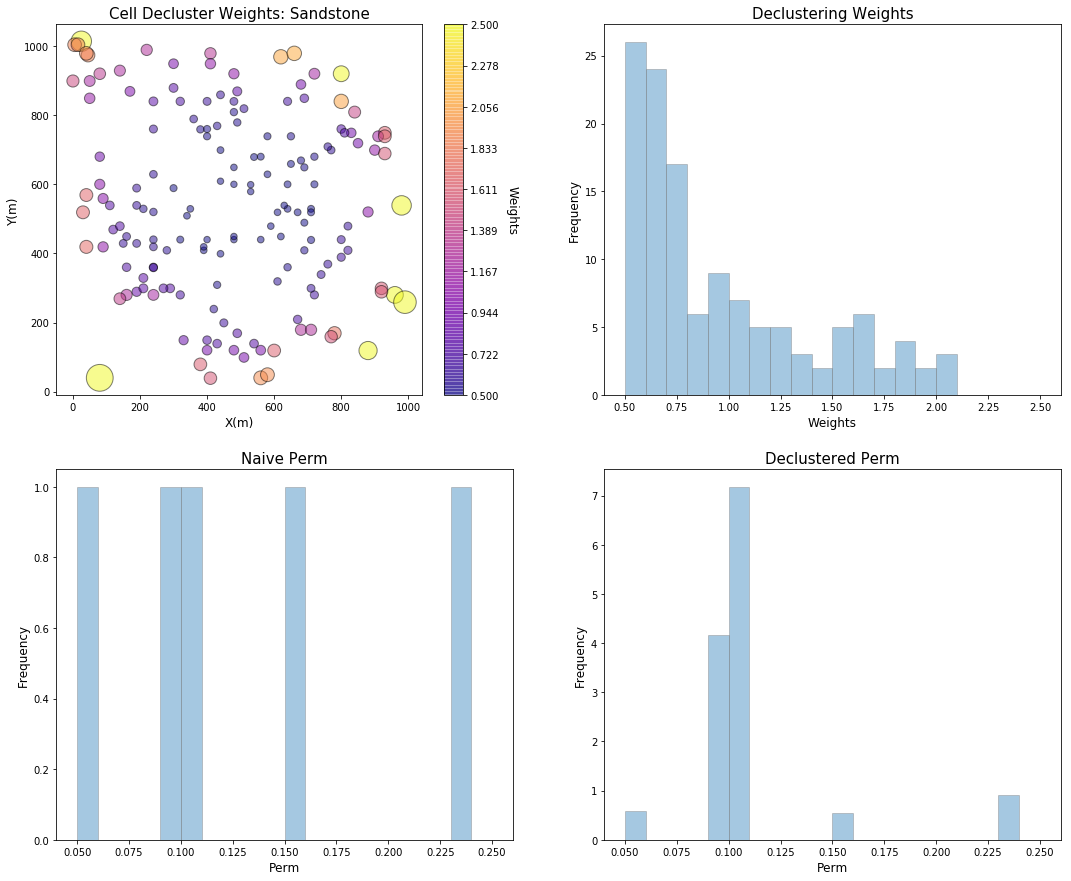

In [46]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of permeability values
im = plt.scatter(sandstone['X'],sandstone['Y'],s=100*sandstone['Wts_perm'],c=sandstone['Wts_perm'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Sandstone', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(sandstone['Wts_perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(sandstone['Perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(sandstone['Perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10],weights=sandstone['Wts_perm'])
plt.title('Declustered Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

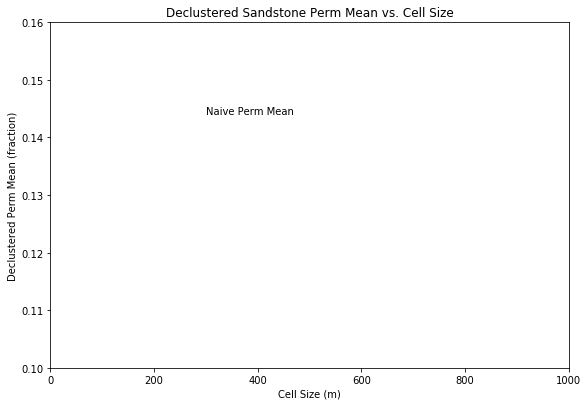

In [47]:
# mean v cell size
por_mean = np.average(sandstone['Perm'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Perm Mean (fraction)')
plt.title('Declustered Sandstone Perm Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.144, r'Naive Perm Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [48]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 18.342773112216555
Corresponding cell size: 485.19999999999953


The entire field of interest is only 1000m x 1000m so it would not be logical to use a cell size close to 500m or half that size. Instead by looking at the plot it appears as if the declustered mean is lowered to an oscillating value by the time the cell size grows to be about 200m.

## 10. Performing Cell Declustering on porosity data (raw data) both facies included

In [49]:
wts, cell_sizes, dmeans = geostats.declus(df_raw,'X','Y','Perm',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
df_raw['Wts_perm'] = wts                            # add weights to the sample data DataFrame
df_raw.head()                                  # preview to check the sample data DataFrame

There are 271 data with:
   mean of      405.800234912934 
   min and max  0.01805446870059259 and 24182.54297248924
   standard dev 2183.309903513707 


,X,Y,Facies,Porosity,Perm,AI,Wts,Wts_perm
3,80.0,280.0,0.0,0.102919,0.196018,6753.323723,1.212966,0.656696
5,160.0,840.0,0.0,0.128852,0.673043,6068.296567,1.008830,1.159927
6,160.0,760.0,0.0,0.103365,5.368073,5574.433666,0.878734,0.826860
7,160.0,680.0,0.0,0.126885,24.314420,4201.709904,0.887110,1.861046
10,160.0,120.0,0.0,0.142252,5.189214,7330.542384,2.489326,2.362052


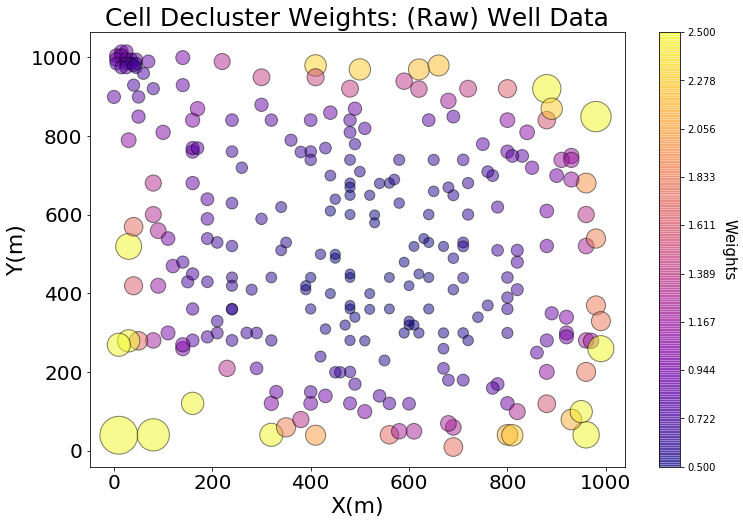

In [50]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of permeability values
plt.figure(figsize=(12,8))
im = plt.scatter(df_raw['X'],df_raw['Y'],s=200*df_raw['Wts'],c=df_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: (Raw) Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

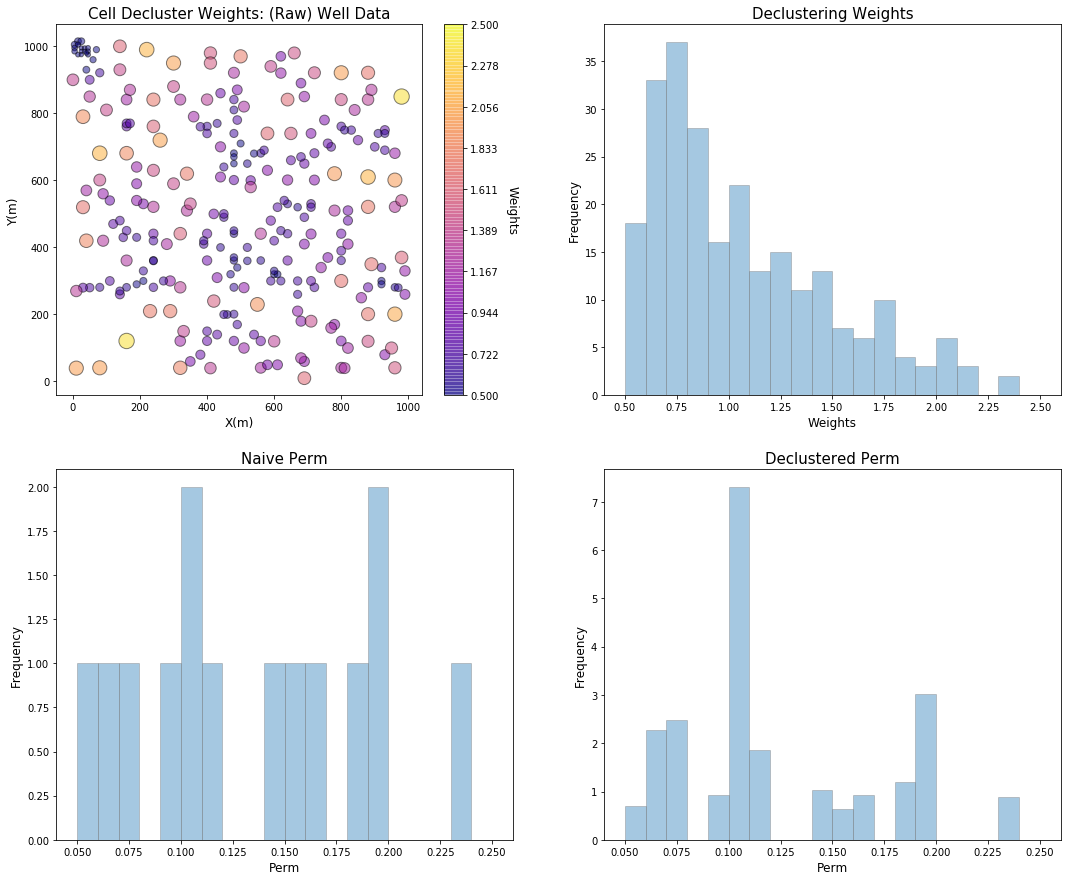

In [51]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(df_raw['X'],df_raw['Y'],s=100*df_raw['Wts_perm'],c=df_raw['Wts_perm'],marker=None,cmap=plt.cm.plasma,norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: (Raw) Well Data', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(df_raw['Wts_perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(df_raw['Perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(df_raw['Perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10],weights=df_raw['Wts'])
plt.title('Declustered Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

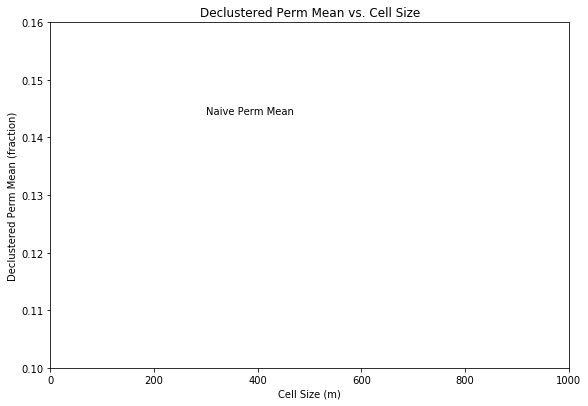

In [52]:
# decluster mean v cell size
por_mean = np.average(df_raw['Perm'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Perm Mean (fraction)')
plt.title('Declustered Perm Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.144, r'Naive Perm Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [53]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 145.3120365494911
Corresponding cell size: 89.2


For a field with dimensions 1000m x 1000m, choosing a cell size of 300m is large, but from looking at the plot of the porosity mean v cell size, choosing 200m cells appears to be a reasonable choice as well.

## 11. Cell declustering on shale porosity values (raw data with outliers)

In [54]:
# Warning that appears is notification that DataFrame is being changed not copied
wts, cell_sizes, dmeans = geostats.declus(shale_raw,'X','Y','Perm',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
shale_raw['Wts'] = wts                            # add weights to the sample data DataFrame
shale_raw.head()                                  # preview to check the sample data DataFrame

There are 62 data with:
   mean of      10.113326112514331 
   min and max  0.01805446870059259 and 208.69091968577183
   standard dev 30.249254890919136 


C:\Users\Navas Archila Family\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,Wts
3,8,80.0,280.0,0.0,0.102919,0.196018,6753.323723,1.064440
5,13,160.0,840.0,0.0,0.128852,0.673043,6068.296567,1.099163
6,14,160.0,760.0,0.0,0.103365,5.368073,5574.433666,0.962821
7,15,160.0,680.0,0.0,0.126885,24.314420,4201.709904,0.899412
10,22,160.0,120.0,0.0,0.142252,5.189214,7330.542384,1.543344


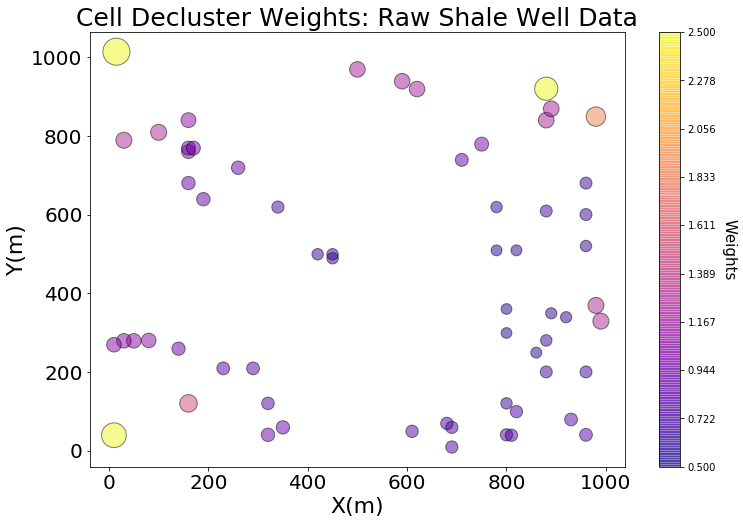

In [55]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of permeability values
plt.figure(figsize=(12,8))
im = plt.scatter(shale_raw['X'],shale_raw['Y'],s=200*shale_raw['Wts'],
                 c=shale_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,
                 vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Shale Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

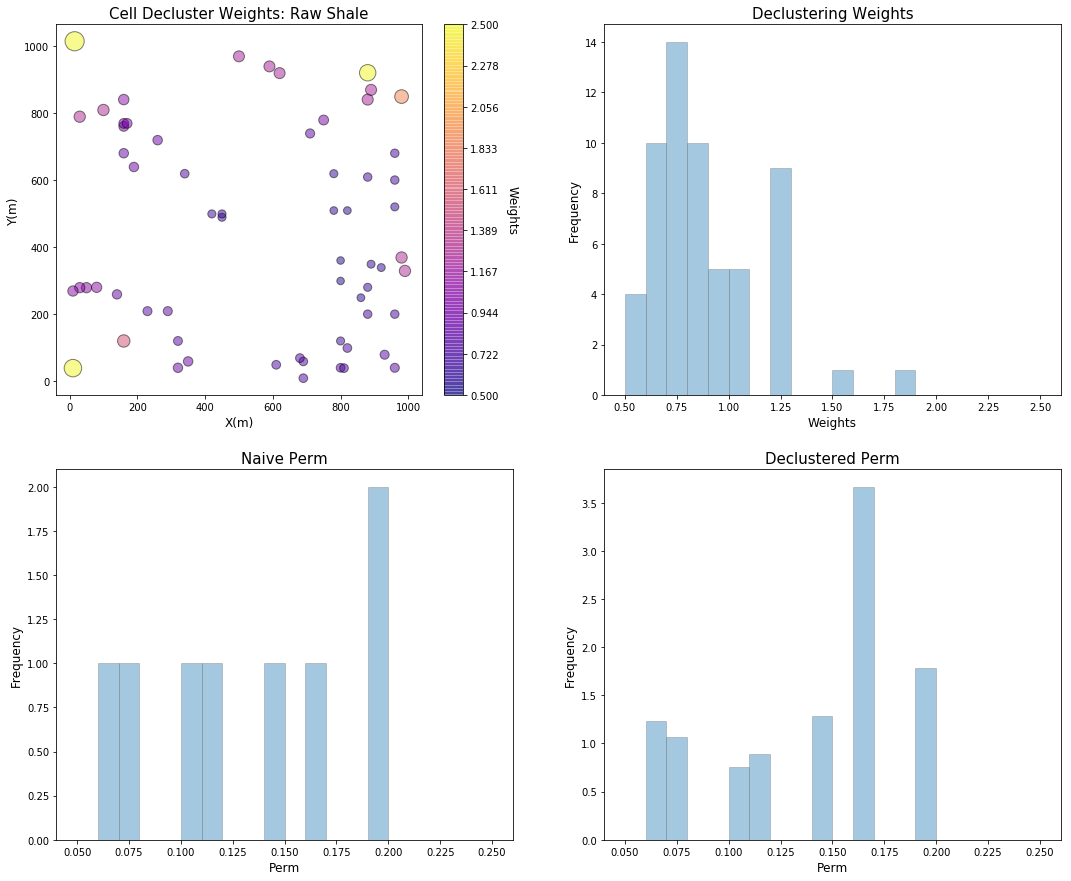

In [56]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of porosity values
im = plt.scatter(shale_raw['X'],shale_raw['Y'],s=100*shale_raw['Wts'],
                 c=shale_raw['Wts'],marker=None,cmap=plt.cm.plasma,
                 norm=None,vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Shale', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(shale_raw['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(shale_raw['Perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(shale_raw['Perm'],edgecolor='gray',bins=20,alpha=0.4,
                     range=[vmin/10,vmax/10],weights=shale_raw['Wts'])
plt.title('Declustered Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

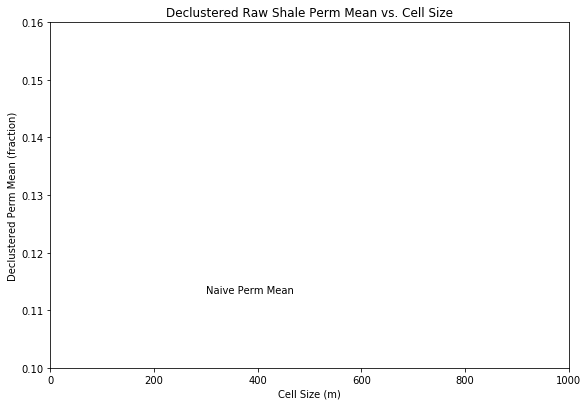

In [57]:
# mean v cell size
por_mean = np.average(shale_raw['Perm'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Perm Mean (fraction)')
plt.title('Declustered Raw Shale Perm Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.113, r'Naive Perm Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [58]:
# find index of minimum declustered value and get corresponding cell size
min_dmeans = dmeans.min()
min_location = np.where(dmeans == min_dmeans)
min_cell = cell_sizes[min_location[0][0]]
print("Minimum value: " + str(min_dmeans))
print("Corresponding cell size: " + str(min_cell))

Minimum value: 8.189414850202915
Corresponding cell size: 960.3999999999985


Visual inspection of the field would suggest that a cell size of ~1000m will not be particularly illuminating. Looking at the plot of the declustered mean against the cell size, it does not appear to favor any particular size.

## 12. Cell declustering on sandstone porosity values (raw data)

In [59]:
# Warning that appears is notification that DataFrame is being changed not copied
wts, cell_sizes, dmeans = geostats.declus(sandstone_raw,'X','Y','Perm',
                                          iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=1000)
sandstone_raw['Wts'] = wts                            # add weights to the sample data DataFrame
sandstone_raw.head()                                  # preview to check the sample data DataFrame

There are 209 data with:
   mean of      523.1810403943983 
   min and max  0.051426329492133584 and 24182.54297248924
   standard dev 2473.9509965030966 


C:\Users\Navas Archila Family\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,Wts
0,0,80.0,920.0,1.0,0.164331,69.106615,5012.616594,0.697078
1,3,80.0,680.0,1.0,0.133723,1.558072,5710.579850,2.527025
2,4,80.0,600.0,1.0,0.096295,3.568959,4912.388066,1.247721
4,11,80.0,40.0,1.0,0.145738,0.109943,6492.944055,3.002240
8,19,160.0,360.0,1.0,0.148611,45.082381,6643.024955,0.764880


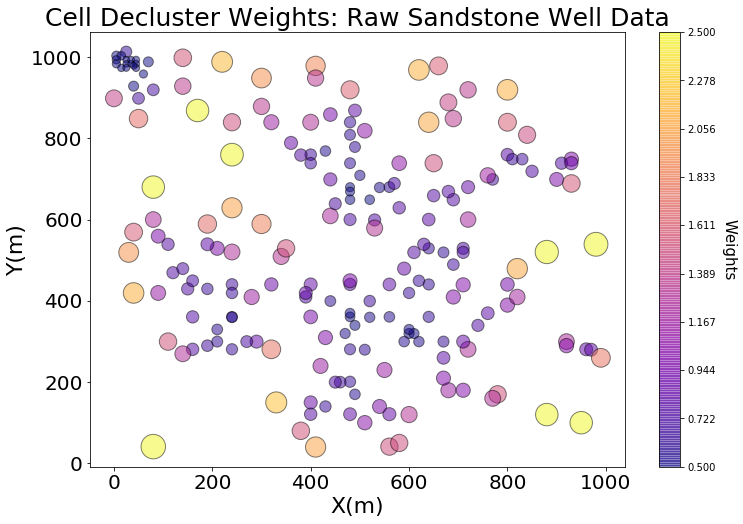

In [60]:
# plotting it my way - scaling point size by weight as well as using color
vmin = 0.5; vmax = 2.5;   # range of permeability values
plt.figure(figsize=(12,8))
im = plt.scatter(sandstone_raw['X'],sandstone_raw['Y'],s=200*sandstone_raw['Wts'],
                 c=sandstone_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,
                 vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Sandstone Well Data', size=25)
plt.xlabel('X(m)', size=22)
plt.xticks(fontsize=20)
plt.ylabel('Y(m)', size=22)
plt.yticks(fontsize=20)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=15)
plt.show()

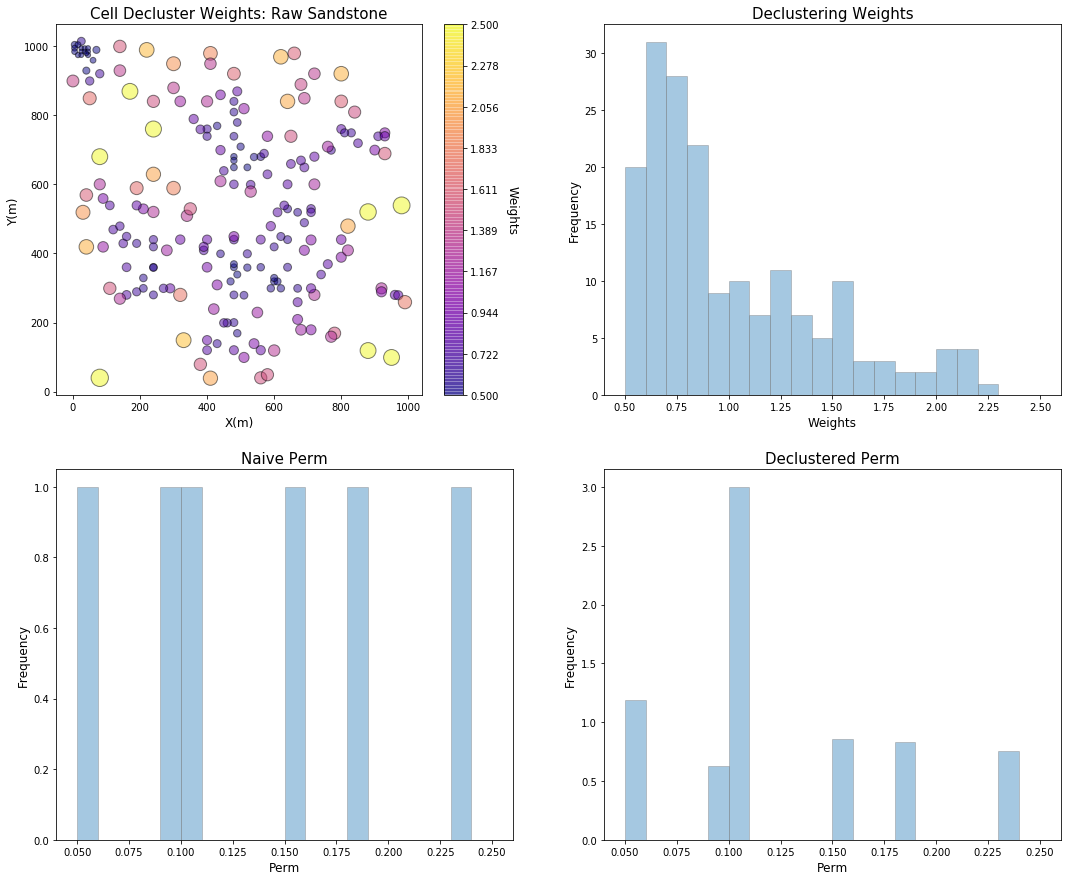

In [61]:
# Plotting histograms with map of decluster weights
plt.figure(figsize=(18,15))

plt.subplot(221)
vmin = 0.5; vmax = 2.5;   # range of permeability values
im = plt.scatter(sandstone_raw['X'],sandstone_raw['Y'],s=100*sandstone_raw['Wts'],
                 c=sandstone_raw['Wts'],marker=None,cmap=plt.cm.plasma,norm=None,
                 vmin=vmin,vmax=vmax,alpha=0.5,verts=None,edgecolors="black")
plt.title('Cell Decluster Weights: Raw Sandstone', size=15)
plt.xlabel('X(m)', size=12)
plt.xticks(fontsize=10)
plt.ylabel('Y(m)', size=12)
plt.yticks(fontsize=10)
cbar = plt.colorbar(im, orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
cbar.set_label('Weights',rotation=270,labelpad=20,size=12)

plt.subplot(222)
whist = plt.hist(sandstone_raw['Wts'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin,vmax])
plt.title('Declustering Weights', size=15)
plt.xlabel('Weights',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(223)
naivehist = plt.hist(sandstone_raw['Perm'],edgecolor='gray',bins=20,alpha=0.4,range=[vmin/10,vmax/10])
plt.title('Naive Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.subplot(224)
decluhist = plt.hist(sandstone_raw['Perm'],edgecolor='gray',bins=20,alpha=0.4,
                     range=[vmin/10,vmax/10],weights=sandstone_raw['Wts'])
plt.title('Declustered Perm',size=15)
plt.xlabel('Perm',size=12)
plt.ylabel('Frequency',size=12)

plt.show()

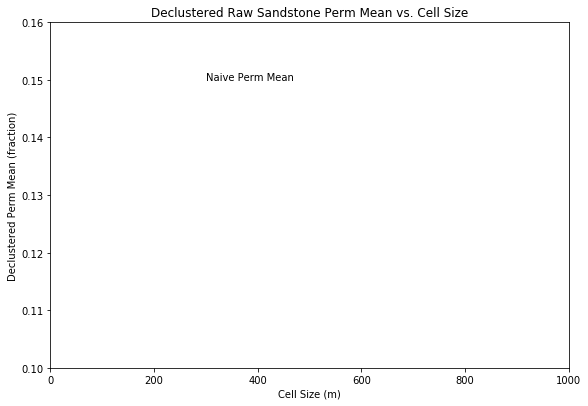

In [62]:
# mean v cell size
por_mean = np.average(sandstone_raw['Perm'].values)
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Perm Mean (fraction)')
plt.title('Declustered Raw Sandstone Perm Mean vs. Cell Size')
plt.plot([0,1000],[por_mean,por_mean],color = 'black')
plt.text(300., 0.150, r'Naive Perm Mean')
plt.ylim(0.10,0.16)
plt.xlim(0,1000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

### Saving data with declustered weights

In [63]:
raw_sandstone = df_raw.loc[(df_raw['Facies'] == 1)] # Group by facies (Sandstone)
raw_shale = df_raw.loc[(df_raw['Facies'] == 0)] # Group by facies (Shale)
raw_sandstone.to_csv('DeclusteredRawSandstone.csv')
raw_shale.to_csv('DeclusteredRawShale.csv')

clean_sandstone = df_clean.loc[(df_clean['Facies'] == 1)] # Group by facies (Sandstone)
clean_shale = df_clean.loc[(df_clean['Facies'] == 0)] # Group by facies (Shale)
clean_sandstone.to_csv('DeclusteredSandstone.csv')
clean_shale.to_csv('DeclusteredShale.csv')

In [64]:
L=1000

In [65]:
samples1 = random.choices(df_clean['Facies'].values, weights=df_clean['Wts'].values, cum_weights=None, k=L)

# **UNCERTAINTY MODEL**

# **Bootstrap to Porosity data**

There are 271 data with:
   mean of      0.14170682372612758 
   min and max  0.0606929054762965 and 0.2216072275194954
   standard dev 0.028288487099816073 


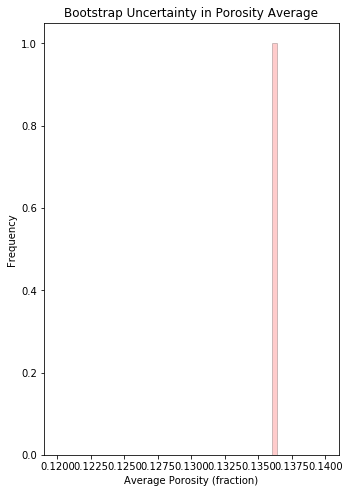

In [74]:
df_raw= pd.read_csv('Data/1_sample_data.csv')
wts, cell_sizes, dmeans = geostats.declus(df2,'X','Y','Porosity', iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df_raw['Wts'] = wts                           # add weights to the sample data DataFrame
L=1000
Boost_Por_Clean = np.zeros(L)
for l in range(0, L):                      # loop over realizations
    samples = random.choices(df_raw['Porosity'].values, weights=df_raw['Wts'].values, cum_weights=None, k=L)
    Boost_Por_Clean = np.average(samples)
      
    
plt.subplot(121)
GSLIB.hist_st(Boost_Por_Clean,0.12,0.14,False,False,50,None,'Average Porosity (fraction)','Bootstrap Uncertainty in Porosity Average')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()   

**Facies proportion Bootstrap - Clean data (Outliers Removed)**

In [83]:
L=1000
def faciesProp_Bootstrap(DataFrame, L): #facies proportions
    fp_sand = np.zeros(L); fp_shale = np.zeros(L)
    for l in np.arange(0, L):                      # loop over realizations
        samples = random.choices(df_clean['Facies'].values, weights=df_clean['Wts'].values, cum_weights=None, k=L)
        samples = np.array(samples)
        fp_sand[l] = list(samples.flatten()).count(1) / len(samples)
        fp_shale[l] = 1 - fp_sand[l]
    
        
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    plt.subplot(111)
    ax1.hist(fp_sand, label='Sand', edgecolor='gray',bins=30, alpha=0.6, color='goldenrod')
    ax1.hist(fp_shale, label = 'Shale', edgecolor='gray',bins=30, alpha=0.6, color='blueviolet')
    ax1.set_xlabel('Facies Proportion', fontsize=15)
    ax1.set_ylabel('Density', fontsize=15)
    ax1.set_title('Facies Proportion (Bootstrap) Clean data', fontsize=20)
    ax1.legend();

    fig.subplots_adjust(left=0.1, bottom=0.1, right=1.5, top=1.5, wspace=0.2, hspace=0.3);


C:\Users\Navas Archila Family\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



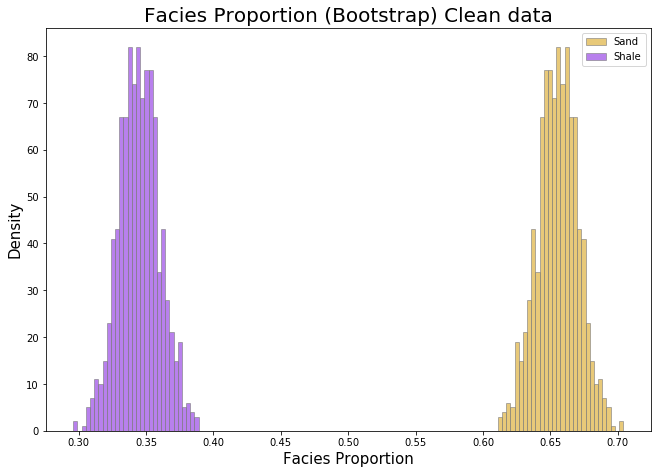

In [84]:
faciesProp_Bootstrap(df_clean['Facies'], 1000)

**Facies proportion Bootstrap - Raw data (With Outliers)**

In [86]:
L=1000
def faciesProp_Bootstrap(DataFrame, L): #facies proportions
    fp_sand = np.zeros(L); fp_shale = np.zeros(L)
    for l in np.arange(0, L):                      # loop over realizations
        samples = random.choices(df_raw['Facies'].values, weights=df_raw['Wts'].values, cum_weights=None, k=L)
        samples = np.array(samples)
        fp_sand[l] = list(samples.flatten()).count(1) / len(samples)
        fp_shale[l] = 1 - fp_sand[l]
        
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    plt.subplot(111)
    ax1.hist(fp_sand, label='Sand', edgecolor='gray',bins=30, alpha=0.6, color='goldenrod')
    ax1.hist(fp_shale, label = 'Shale', edgecolor='gray',bins=30, alpha=0.6, color='blueviolet')
    ax1.set_xlabel('Facies Proportion', fontsize=15)
    ax1.set_ylabel('Density', fontsize=15)
    ax1.set_title('Facies Proportion (Bootstrap) Clean data', fontsize=20)
    ax1.legend();

    fig.subplots_adjust(left=0.1, bottom=0.1, right=1.5, top=1.5, wspace=0.2, hspace=0.3);
    

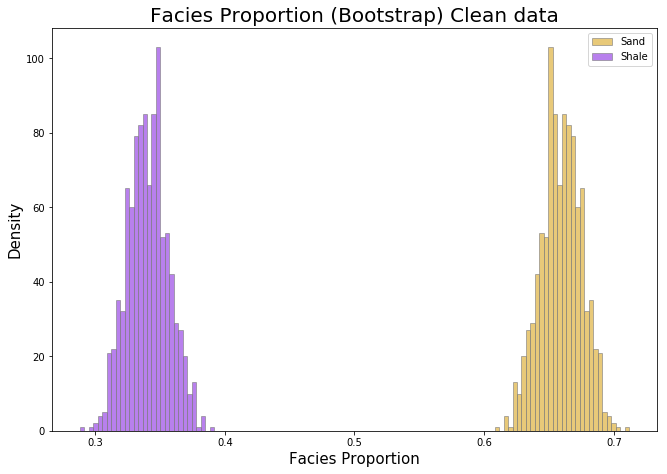

In [87]:
faciesProp_Bootstrap(df_clean['Facies'], 1000)